# Get It

This code downloads the chorales and saves them as midi in a folder "JS Chorales"

In [1]:
"""
Example of iterating Bach Chorales and getting individual voice parts
In this case, want specifically 4 voice pieces only
Also transpose to key of C (major or minor depending on piece)
Also shows how to write out all the xml as midi
"""
# Author: Kyle Kastner
# License: BSD 3-Clause
# Based on StackOverflow answer
# http://stackoverflow.com/questions/36647054/music21-getting-all-notes-with-durations
# midi writing modified from tests inside music21
from music21 import corpus, interval, pitch
import time
import numpy as np
import os


def write_midi(pitch_block, duration_block, outfile="out.mid",
               qpm_multiplier=1024, tempo_multiplier=1.0):
    # Assumes any element with
    from music21.midi import MidiTrack, MidiFile, MidiEvent, DeltaTime
    # duration, pitch, velocity

    qpm_mult = qpm_multiplier
    all_mt = []

    for i in range(pitch_block.shape[0]):
        mt = MidiTrack(1)
        t = 0
        t_last = 0
        pitch_slice = pitch_block[i, :]
        duration_slice = duration_block[i, :]
        beat_slice = list((qpm_mult * duration_slice).astype("int32"))
        pitch_slice = list(pitch_slice.astype("int32"))
        for d, p in zip(beat_slice, pitch_slice):
            if (p == -1) or (d == -1):
                # bypass
                continue
            dt = DeltaTime(mt)
            dt.time = t - t_last
            mt.events.append(dt)

            me = MidiEvent(mt)
            me.type = "NOTE_ON"
            me.channel = 1
            me.time = None
            me.pitch = p
            me.velocity = 90
            mt.events.append(me)

            # add note off / velocity zero message
            dt = DeltaTime(mt)
            dt.time = d
            # add to track events
            mt.events.append(dt)

            me = MidiEvent(mt)
            me.type = "NOTE_ON"
            me.channel = 1
            me.time = None
            me.pitch = p
            me.velocity = 0
            mt.events.append(me)
            t_last = t + d
            t += d

        # add end of track
        dt = DeltaTime(mt)
        dt.time = 0
        mt.events.append(dt)

        me = MidiEvent(mt)
        me.type = "END_OF_TRACK"
        me.channel = 1
        me.data = ''
        mt.events.append(me)
        all_mt.append(mt)

    mf = MidiFile()
    mf.ticksPerQuarterNote = int(tempo_multiplier * qpm_mult)
    for mt in all_mt:
        mf.tracks.append(mt)

    mf.open(outfile, 'wb')
    mf.write()
    mf.close()


start = time.time()
all_bach_paths = corpus.getComposer('bach')
print("Total number of Bach pieces to process from music21: %i" % len(all_bach_paths))
skipped = 0
processed = 0
n_major = 0
n_minor = 0
all_major = []
all_minor = []
for it, p_bach in enumerate(all_bach_paths):
    if "riemenschneider" in str(p_bach):
        # skip certain files we don't care about
        skipped += 1
        continue
    p = corpus.parse(p_bach)
    if len(p.parts) != 4:
        print("Skipping file %i, %s due to undesired voice count..." % (it, p_bach))
        skipped += 1
        continue
    print("Processing %i, %s ..." % (it, p_bach))

    k = p.analyze('key')
    print("Original key: %s" % k)
    i = interval.Interval(k.tonic, pitch.Pitch('C'))
    p = p.transpose(i)
    k = p.analyze('key')
    print("Transposed key: %s" % k)
    if 'major' in k.name:
        n_major += 1
    elif 'minor' in k.name:
        n_minor += 1
    else:
        raise ValueError('Unknown key %s' % k.name)

    try:
        parts = []
        parts_times = []
        for i, pi in enumerate(p.parts):
            part = []
            part_time = []
            for n in pi.stream().flat.notesAndRests:
                if n.isRest:
                    part.append(0)
                else:
                    part.append(n.midi)
                part_time.append(n.duration.quarterLength)
            parts.append(part)
            parts_times.append(part_time)

        # Create a "block" of events and times
        cumulative_times = map(lambda x: list(np.cumsum(x)), parts_times)
        event_points = sorted(list(set(sum(cumulative_times, []))))
        maxlen = max(map(len, cumulative_times))
        # -1 marks invalid / unused
        part_block = np.zeros((len(p.parts), maxlen)).astype("int32") - 1
        ctime_block = np.zeros((len(p.parts), maxlen)).astype("float32") - 1
        time_block = np.zeros((len(p.parts), maxlen)).astype("float32") - 1
        # create numpy array for easier indexing
        for i in range(len(parts)):
            part_block[i, :len(parts[i])] = parts[i]
            ctime_block[i, :len(cumulative_times[i])] = cumulative_times[i]
            time_block[i, :len(parts_times[i])] = parts_times[i]

        event_block = np.zeros((len(p.parts), len(event_points))) - 1
        etime_block = np.zeros((len(p.parts), len(event_points))) - 1
        for i, e in enumerate(event_points):
            idx = zip(*np.where(ctime_block == e))
            for ix in idx:
                event_block[ix[0], i] = part_block[ix[0], ix[1]]
                etime_block[ix[0], i] = time_block[ix[0], ix[1]]

        bach_name = "_".join(p_bach.split(os.sep)[-1].split(".")[:-1])
        midi_outfile = bach_name + ".mid"
        write_midi(event_block, etime_block,
                   outfile="midifiles/" + midi_outfile,
                   tempo_multiplier=1.0)
        # Grouping
        processed += 1
    except AttributeError:
        skipped += 1
        # Edge case for Chord error? Should be flat container but some piece is different
        continue

stop = time.time()
print("Total skipped count: %i" % skipped)
print("Total processed count: %i" % processed)
print("Total major: %i" % n_major)
print("Total minor: %i" % n_minor)
print("Total processing time (seconds): %f" % (stop - start))

Total number of Bach pieces to process from music21: 433
Skipping file 0, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv1.6.mxl due to undesired voice count...
Processing 1, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv10.7.mxl ...
Original key: g minor
Transposed key: c minor
Processing 2, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv101.7.mxl ...
Original key: d minor
Transposed key: c minor
Processing 3, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv102.7.mxl ...
Original key: c minor
Transposed key: c minor
Processing 4, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv103.6.mxl ...
Original key: b minor
Transposed key: c minor
Processing 5, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv104.6.mxl ...
Original key: A major
Transposed key: C major
Processing 6, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv108.6.mxl ...
Original key: b minor
Transposed key: c m

Transposed key: C major
Processing 60, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv165.6.mxl ...
Original key: G major
Transposed key: C major
Processing 61, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv166.6.mxl ...
Original key: g minor
Transposed key: c minor
Processing 62, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv168.6.mxl ...
Original key: b minor
Transposed key: c minor
Processing 63, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv169.7.mxl ...
Original key: A major
Transposed key: C major
Processing 64, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv17.7.mxl ...
Original key: A major
Transposed key: C major
Skipping file 65, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv171.6.mxl due to undesired voice count...
Skipping file 66, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv172.6.mxl due to undesired voice count...
Processing 67, C:\Anaconda\envs\er

Original key: E- major
Transposed key: C major
Processing 120, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv245.28.mxl ...
Original key: A major
Transposed key: C major
Processing 121, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv245.3.mxl ...
Original key: g minor
Transposed key: c minor
Processing 122, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv245.37.mxl ...
Original key: b- minor
Transposed key: c minor
Processing 123, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv245.40.mxl ...
Original key: E- major
Transposed key: C major
Processing 124, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv245.5.mxl ...
Original key: d minor
Transposed key: c minor
Processing 125, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv248.12-2.mxl ...
Original key: G major
Transposed key: C major
Skipping file 126, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv248.17.mxl due to unde

Transposed key: C major
Processing 180, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv281.mxl ...
Original key: F major
Transposed key: C major
Processing 181, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv282.mxl ...
Original key: G major
Transposed key: C major
Processing 182, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv283.mxl ...
Original key: a minor
Transposed key: c minor
Processing 183, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv284.mxl ...
Original key: g minor
Transposed key: c minor
Processing 184, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv285.mxl ...
Original key: c minor
Transposed key: c minor
Processing 185, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv286.mxl ...
Original key: a minor
Transposed key: c minor
Processing 186, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv287.mxl ...
Original key: F major
Transposed key: C major
Processing

Transposed key: c minor
Processing 240, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv335.mxl ...
Original key: b minor
Transposed key: c minor
Processing 241, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv336.mxl ...
Original key: A major
Transposed key: C major
Processing 242, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv337.mxl ...
Original key: a minor
Transposed key: c minor
Processing 243, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv338.mxl ...
Original key: a minor
Transposed key: c minor
Processing 244, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv339.mxl ...
Original key: A major
Transposed key: C major
Processing 245, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv340.mxl ...
Original key: a minor
Transposed key: c minor
Processing 246, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv341.mxl ...
Original key: g minor
Transposed key: c minor
Processing

Transposed key: C major
Processing 300, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv39.7.mxl ...
Original key: B- major
Transposed key: C major
Processing 301, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv390.mxl ...
Original key: C major
Transposed key: C major
Processing 302, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv391.mxl ...
Original key: G major
Transposed key: C major
Processing 303, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv392.mxl ...
Original key: B- major
Transposed key: C major
Processing 304, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv393.mxl ...
Original key: A major
Transposed key: C major
Processing 305, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv394.mxl ...
Original key: A major
Transposed key: C major
Processing 306, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv395.mxl ...
Original key: A major
Transposed key: C major
Process

Transposed key: c minor
Processing 360, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv47.5.mxl ...
Original key: g minor
Transposed key: c minor
Processing 361, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv48.3.mxl ...
Original key: B- major
Transposed key: C major
Processing 362, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv48.7.mxl ...
Original key: g minor
Transposed key: c minor
Processing 363, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv5.7.mxl ...
Original key: g minor
Transposed key: c minor
Skipping file 364, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv52.6.mxl due to undesired voice count...
Processing 365, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv55.5.mxl ...
Original key: B- major
Transposed key: C major
Processing 366, C:\Anaconda\envs\eric3\Lib\site-packages\music21\corpus\bach\bwv56.5.mxl ...
Original key: c minor
Transposed key: c minor
Processing 367, C

# Parse It to array

In [18]:
from mido import MidiFile
# mid = MidiFile('JSB Chorales/train/3.mid')

In [19]:
def compute_note_positions(mid):
    current_tick = 0
    event_absolute_position = []

    """
    Each message in a MIDI file has a delta time, which tells how many ticks have passed since the last message. 
    The length of a tick is defined in ticks per beat. 
    This value is stored as ticks_per_beat in MidiFile objects and remains fixed throughout the song.
    """
    notes = []
    for i, track in enumerate(mid.tracks):
#         print('Track {}: {}'.format(i, track.name))
        for msg in track:
            msg_data = msg.dict()
            event_type, time, note = msg_data['type'], msg_data['time'], msg_data.get('note', -1)
#             print("Event: {:10} Time: {:4}   Note: {:3}".format(event_type, time, note))

            if event_type.startswith('note'):
                notes.append((event_type, current_tick, note))

            event_absolute_position.append(current_tick)
            current_tick += time

    return notes

In [20]:
def get_note_array(notes):
#     df = pd.DataFrame(np.zeros((current_tick, 128)))
    X = np.zeros((current_tick, 128))
    
    for event, tick, note in notes:
        if event == 'note_on':
            X[tick:, note] = 1

        if event == 'note_off':
            X[tick:, note] = 0
            
    return X

In [21]:
X = get_note_array(compute_note_positions(mid))

In [22]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

# Does it work? Chorale train/2.mid looks/sounds weird...

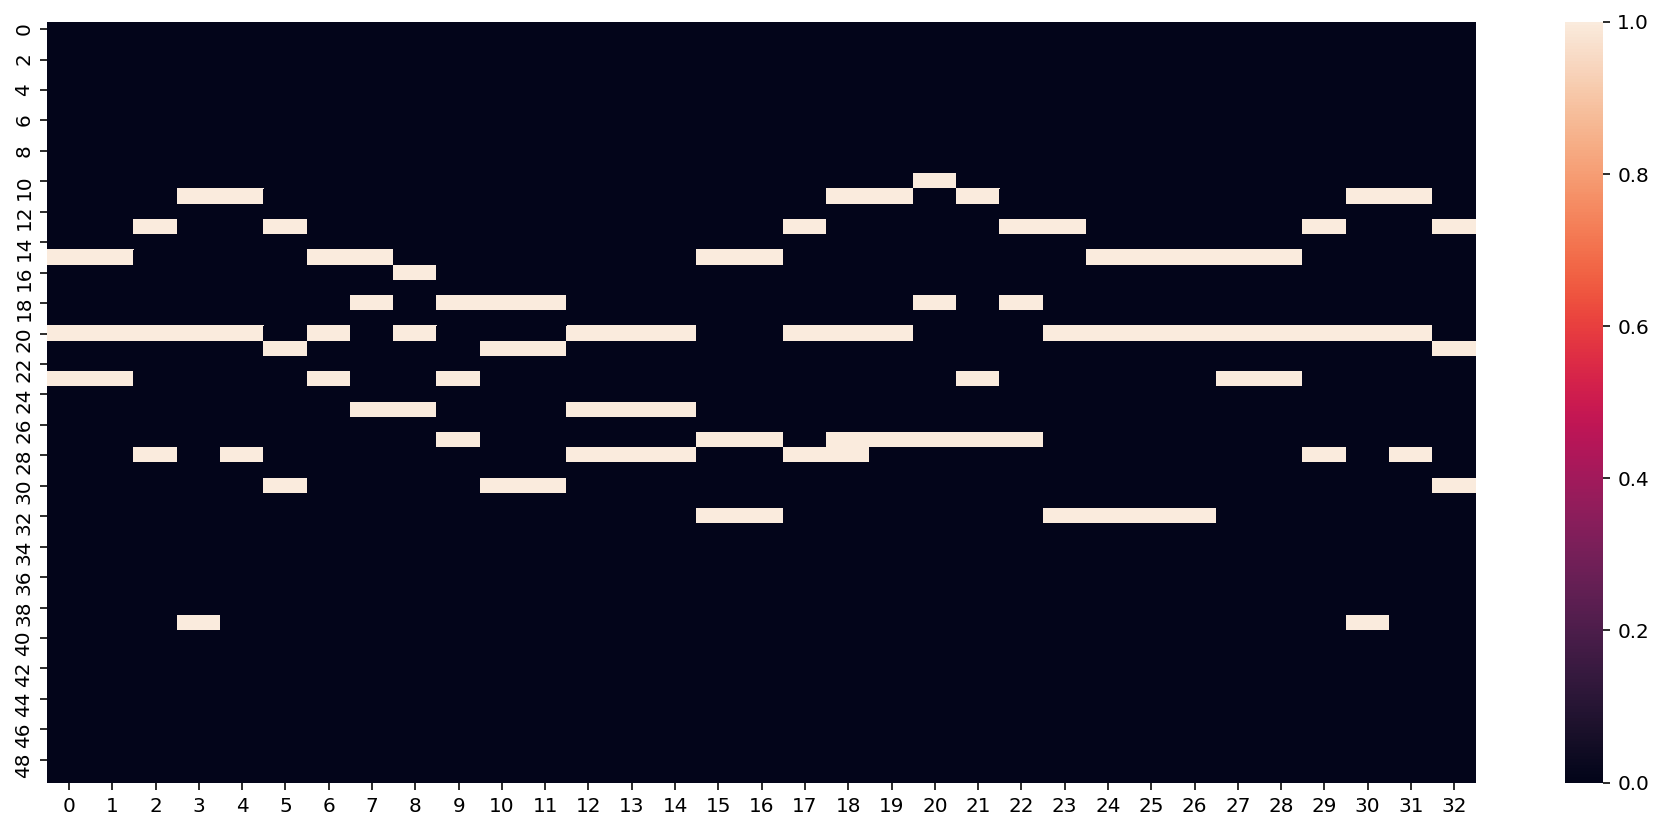

In [23]:
plt.figure(figsize=(16, 7))
sn.heatmap(X.T[50: 100, ::120][::-1])
plt.show()

# This looks fishy, there are usually 4 voices in a chorale. Next loop processes all the midi

except for the break...

In [24]:
import os

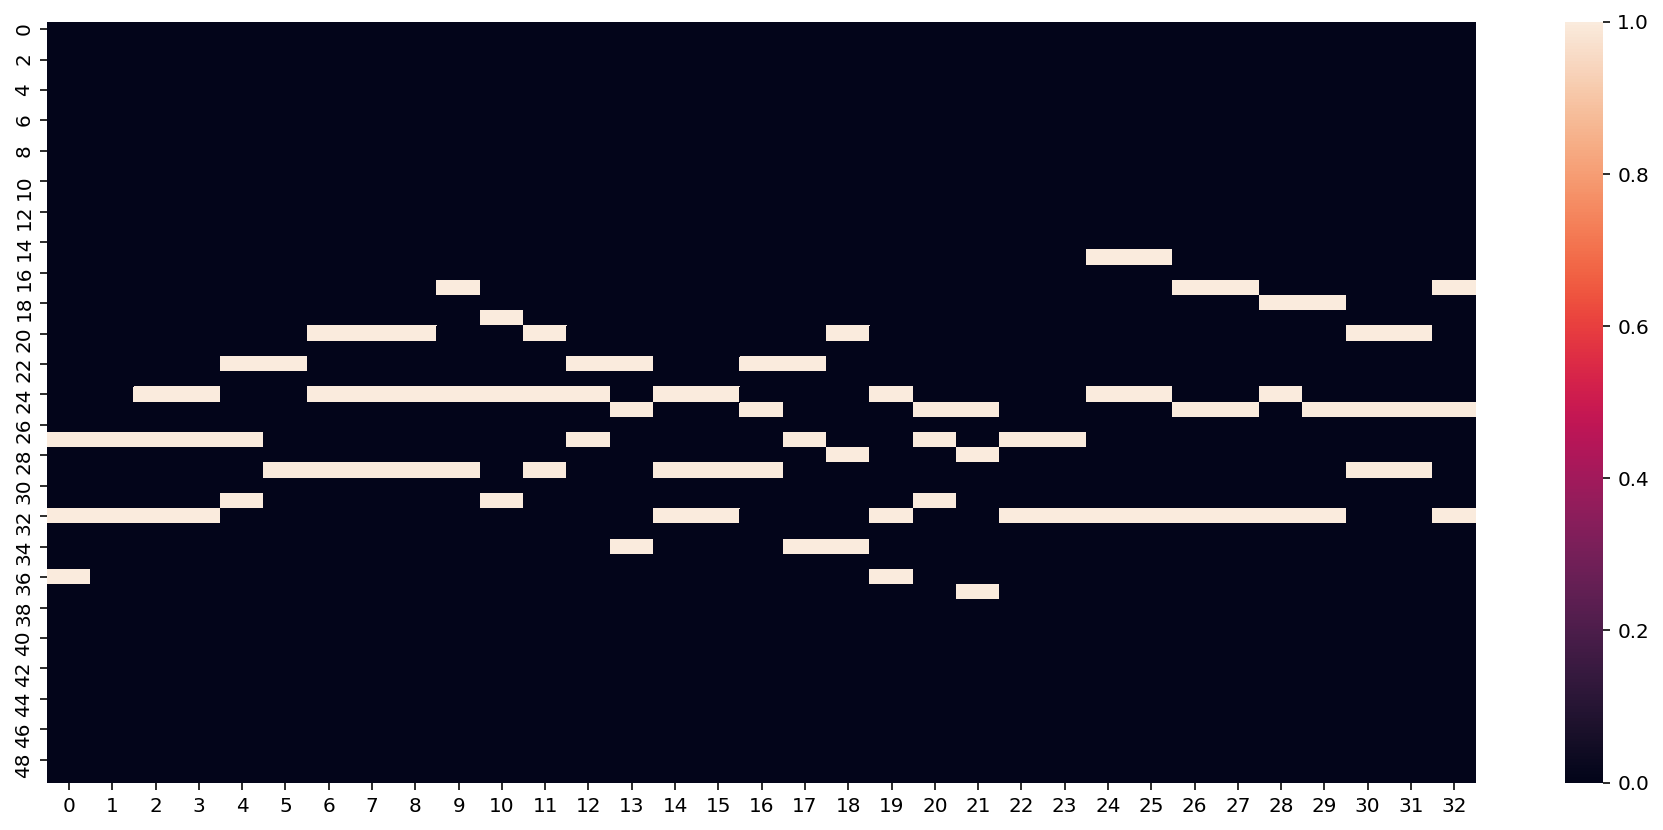

In [27]:
train_set = []

path = 'JSB Chorales/train'
for f in os.listdir(path):
    mid = MidiFile(os.path.join(path, f))
    X = get_note_array(compute_note_positions(mid))
    plt.figure(figsize=(16, 7))
    sn.heatmap(X.T[50: 100, ::120][::-1])
    plt.show()
    train_set.append(X)
    
    break # remove me